#**Proyecto: Análisis de working capital con clustering**

Objetivo: **Comparar dos enfoques de clasificación para mejorar la toma de decisiones en gestión de inventario y demanda**. Uno por fuerza bruta (Excel – teoría ABC/XYZ), usado actualmente por la empresa, y otro de Machine Learning, usando métodos de clustering (K-Means / DBSCAN).

De esta forma se analizará ahorro de tiempo que proporciona el método de clustering con respecto al método usado, y si los resultados son similares o se obtienen mejoras en la toma de decisiones con el uso de Machine Learning.

#**Parte 1: Importación de datos**

In [ ]:
#creando conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#instalar librería para importación de archivos .xlsx
!pip install openpyxl

In [ ]:
import pandas as pd
import openpyxl

In [ ]:
#IMPORTANTE: usar este enlace, asegurarse de que en sus Drive la ruta sea la misma:
#en su carpeta "Compartido conmigo" de su Drive hacer click derecho en la carpeta "Hakaton grupo 4" y "agregar acceso directo a Mi Unidad"
#asi se aseguran que la ruta de acceso al archivo sea la misma para todos
pd.read_excel('/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx')

#corroborar ruta del archivo
!ls '/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx'

'/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx'


In [ ]:
#creando objetos por cada hoja del archivo Excel
datos_prod = pd.read_excel('/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx', sheet_name="Datos Prod")
ventas_mes = pd.read_excel('/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx', sheet_name="Ventas mes")
clientes = pd.read_excel('/content/drive/MyDrive/Hakaton grupo 4/Copia de DataSet Hakaton grupo 4.xlsx', sheet_name="Ventas KG cliente")

In [ ]:
#ver columnas y estructura de cada dataframe creado
print(datos_prod.keys())
print(ventas_mes.keys())
print(clientes.keys())


Index(['Prod ID', 'CMG av (USD/kg)', 'Tiempo de entrega (semanas)',
       'VU (meses)', 'Cantidad de clientes históricamente (unidad)',
       'Precio (USD/kg)'],
      dtype='object')
Index([         'Producto', 2021-06-01 00:00:00, 2021-07-01 00:00:00,
       2021-08-01 00:00:00, 2021-09-01 00:00:00, 2021-10-01 00:00:00,
       2021-11-01 00:00:00, 2021-12-01 00:00:00, 2022-01-01 00:00:00,
       2022-02-01 00:00:00, 2022-03-01 00:00:00, 2022-04-01 00:00:00,
       2022-05-01 00:00:00, 2022-06-01 00:00:00, 2022-07-01 00:00:00,
       2022-08-01 00:00:00, 2022-09-01 00:00:00, 2022-10-01 00:00:00,
       2022-11-01 00:00:00, 2022-12-01 00:00:00, 2023-01-01 00:00:00,
       2023-02-01 00:00:00, 2023-03-01 00:00:00, 2023-04-01 00:00:00,
       2023-05-01 00:00:00, 2023-06-01 00:00:00, 2023-07-01 00:00:00,
       2023-08-01 00:00:00, 2023-09-01 00:00:00, 2023-10-01 00:00:00,
       2023-11-01 00:00:00, 2023-12-01 00:00:00, 2024-01-01 00:00:00,
       2024-02-01 00:00:00, 2024-03-01 00:00

In [ ]:
#cambiamos el nombre de la columna Producto (o Cod Prod) para unificarlo y que sea igual en todos los dataframes
ventas_mes = ventas_mes.rename(columns={'Producto': 'Prod ID'})
clientes = clientes.rename(columns={'Cod Prod': 'Prod ID'})
print(ventas_mes.columns)
print(clientes.columns)

Index([          'Prod ID', 2021-06-01 00:00:00, 2021-07-01 00:00:00,
       2021-08-01 00:00:00, 2021-09-01 00:00:00, 2021-10-01 00:00:00,
       2021-11-01 00:00:00, 2021-12-01 00:00:00, 2022-01-01 00:00:00,
       2022-02-01 00:00:00, 2022-03-01 00:00:00, 2022-04-01 00:00:00,
       2022-05-01 00:00:00, 2022-06-01 00:00:00, 2022-07-01 00:00:00,
       2022-08-01 00:00:00, 2022-09-01 00:00:00, 2022-10-01 00:00:00,
       2022-11-01 00:00:00, 2022-12-01 00:00:00, 2023-01-01 00:00:00,
       2023-02-01 00:00:00, 2023-03-01 00:00:00, 2023-04-01 00:00:00,
       2023-05-01 00:00:00, 2023-06-01 00:00:00, 2023-07-01 00:00:00,
       2023-08-01 00:00:00, 2023-09-01 00:00:00, 2023-10-01 00:00:00,
       2023-11-01 00:00:00, 2023-12-01 00:00:00, 2024-01-01 00:00:00,
       2024-02-01 00:00:00, 2024-03-01 00:00:00, 2024-04-01 00:00:00,
       2024-05-01 00:00:00, 2024-06-01 00:00:00, 2024-07-01 00:00:00,
       2024-08-01 00:00:00, 2024-09-01 00:00:00, 2024-10-01 00:00:00,
       2024-11-01 00

In [ ]:
#Crear una nueva columna en datos_prod que puede ayudar en el clustering: desviación estandar.
#Para ello debo seleccionar solo los valores numéricos de ventas_mes

numeric_ventas_mes = ventas_mes.select_dtypes(include=['number']) #selecciona solo columnas con datos numéricos del df
datos_prod["std_fila"] = numeric_ventas_mes.std(axis=1, ddof=0) #calcula desviación estándar de cada fila y crea nueva columna
print(datos_prod)

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (meses)  \
0    T1981            0.000                           11          24   
1    T1872            0.000                           13          12   
2    T1763            0.798                           12          60   
3    T1654            1.056                           12          60   
4    T1545            0.000                           13          12   
..     ...              ...                          ...         ...   
87   T0278            0.000                           12          12   
88   T0169            0.026                            8          12   
89   T0091            0.000                           19          36   
90   T0082            0.000                           13          12   
91   T0073            0.000                           16          24   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                              1         1.250000 

In [ ]:
#También deberíamos normalizar los valores por ejemplo de meses y semanas porque va a ser más fácil para ver relación. Voy a pasar todo a semanas para que sea más simple
datos_prod['VU (meses)']=datos_prod['VU (meses)']*4.35
datos_prod.rename(columns={"VU (meses)": "VU (semanas)"}, inplace=True)
print(datos_prod)

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
0    T1981            0.000                           11         104.4   
1    T1872            0.000                           13          52.2   
2    T1763            0.798                           12         261.0   
3    T1654            1.056                           12         261.0   
4    T1545            0.000                           13          52.2   
..     ...              ...                          ...           ...   
87   T0278            0.000                           12          52.2   
88   T0169            0.026                            8          52.2   
89   T0091            0.000                           19         156.6   
90   T0082            0.000                           13          52.2   
91   T0073            0.000                           16         104.4   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                         

In [ ]:
#para el clustering también me va a servir hacer la CMG total, es decir CMG unitaria * total kg de producto
columnas_a_sumar = ventas_mes.iloc[:, 2:61].columns
datos_prod["total_ventas"] = ventas_mes[columnas_a_sumar].sum(axis=1)
datos_prod["total_CMG"]=datos_prod['total_ventas']*datos_prod['CMG av (USD/kg)']
print(datos_prod)

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
0    T1981            0.000                           11         104.4   
1    T1872            0.000                           13          52.2   
2    T1763            0.798                           12         261.0   
3    T1654            1.056                           12         261.0   
4    T1545            0.000                           13          52.2   
..     ...              ...                          ...           ...   
87   T0278            0.000                           12          52.2   
88   T0169            0.026                            8          52.2   
89   T0091            0.000                           19         156.6   
90   T0082            0.000                           13          52.2   
91   T0073            0.000                           16         104.4   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                         

In [ ]:
#hay productos con 0 ventas en los 5 años. Esos, vamos a intentar eliminarlos para limpiar un poco. Aquellos cuya CMG_total es cero pero que tienen volumen puede ser un error de las tablas de datos, no ha quedado registrada la CMG (puede que se haya hecho solo una entrega a cliente gratis como muestra para pruebas industriales, o tal vez hubo gastos inesperados de importacion que hicieron que el precio de venta no alcance para cubrir los costos del producto, como no sabemos por qué, esos los vamos a dejar sin eliminar del dataset)
productos_sin_ventas = datos_prod[datos_prod["total_ventas"] == 0]["Prod ID"]

print(f"Productos eliminados ({len(productos_sin_ventas)}):")
print(productos_sin_ventas)

Productos eliminados (2):
16    T2188
90    T0082
Name: Prod ID, dtype: object


In [ ]:
ventas_mes = ventas_mes[~ventas_mes["Prod ID"].isin(productos_sin_ventas)]
datos_prod = datos_prod[~datos_prod["Prod ID"].isin(productos_sin_ventas)]
clientes = clientes[~clientes["Prod ID"].isin(productos_sin_ventas)]

In [ ]:
#transformar el dataframe ventas_mes de formato ancho a formato largo
ventas_mes_largo=pd.melt(ventas_mes, id_vars='Prod ID', var_name='Mes', value_name='KG')
ventas_mes_largo.head()

,Prod ID,Mes,KG
0,T1981,2021-06-01 00:00:00,0.0
1,T1872,2021-06-01 00:00:00,38950.0
2,T1763,2021-06-01 00:00:00,0.0
3,T1654,2021-06-01 00:00:00,0.0
4,T1545,2021-06-01 00:00:00,0.0


In [ ]:
ventas_mes_largo.info()
print(ventas_mes_largo.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Prod ID  4320 non-null   object 
 1   Mes      4320 non-null   object 
 2   KG       4320 non-null   float64
dtypes: float64(1), object(2)
memory usage: 101.4+ KB
(4320, 3)


#**Parte 2: Análisis exploratorio y visualización de datos (EDA)**

In [ ]:
#observando características del dataframe
datos_prod.head()
datos_prod.info()
datos_prod.describe()
datos_prod.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 91
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Prod ID                                       90 non-null     object 
 1   CMG av (USD/kg)                               90 non-null     float64
 2   Tiempo de entrega (semanas)                   90 non-null     int64  
 3   VU (semanas)                                  90 non-null     float64
 4   Cantidad de clientes históricamente (unidad)  90 non-null     int64  
 5   Precio (USD/kg)                               90 non-null     float64
 6   std_fila                                      90 non-null     float64
 7   total_ventas                                  90 non-null     float64
 8   total_CMG                                     90 non-null     float64
dtypes: float64(6), int64(2), object(1)
memory usage: 7.0+ KB


,0
Prod ID,object
CMG av (USD/kg),float64
Tiempo de entrega (semanas),int64
VU (semanas),float64
Cantidad de clientes históricamente (unidad),int64
Precio (USD/kg),float64
std_fila,float64
total_ventas,float64
total_CMG,float64


In [ ]:
#observando características del dataframe
ventas_mes_largo.info()
ventas_mes_largo.describe()
ventas_mes_largo.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Prod ID  4320 non-null   object 
 1   Mes      4320 non-null   object 
 2   KG       4320 non-null   float64
dtypes: float64(1), object(2)
memory usage: 101.4+ KB


,0
Prod ID,object
Mes,object
KG,float64


In [ ]:
#Importando librerías para visualizacion de las variables
import seaborn as sns
import plotly.express as px

In [ ]:
df_visual = ventas_mes_largo.merge(datos_prod[['Prod ID', 'CMG av (USD/kg)']], on='Prod ID', how='left')
print(df_visual)

     Prod ID                  Mes       KG  CMG av (USD/kg)
0      T1981  2021-06-01 00:00:00      0.0            0.000
1      T1872  2021-06-01 00:00:00  38950.0            0.000
2      T1763  2021-06-01 00:00:00      0.0            0.798
3      T1654  2021-06-01 00:00:00      0.0            1.056
4      T1545  2021-06-01 00:00:00      0.0            0.000
...      ...                  ...      ...              ...
4315   T0387  2025-05-01 00:00:00      0.0            0.000
4316   T0278  2025-05-01 00:00:00      0.0            0.000
4317   T0169  2025-05-01 00:00:00  80000.0            0.026
4318   T0091  2025-05-01 00:00:00   1200.0            0.000
4319   T0073  2025-05-01 00:00:00      0.0            0.000

[4320 rows x 4 columns]


In [ ]:
fig = px.line(df_visual,
              x='Mes',
              y='KG',
              color='Prod ID',
              hover_data=['CMG av (USD/kg)'],
              title='Ventas mensuales por producto y CMG promedio',
              markers=True)
fig.show()

En el gráfico de líneas se puede observar la evolución de ventas entre los años 2021 y 2025 para todos los productos de la empresa, por cantidad de Kg. vendidos, lo que dificulta distinguir tendencias debido a la saturación de elementos.
Así que vamos a reducir la cantidad de productos mostrados, dejando solo los más significativos.

In [ ]:
#son muchos, vamos a limpiar y dejar solo los más representativos. A simple vista, se nota que son poquitos los productos que tienen mucho volumen.
#Tomo para decir "más representativos" los que cuento por arriba de 70k.
ventas_grandes = ventas_mes_largo[ventas_mes_largo["KG"] > 70000]["Prod ID"]
ventas_grandes_unicos =ventas_grandes.unique()
print(ventas_grandes_unicos)


['T6019' 'T7171' 'T3282' 'T1763' 'T2861' 'T0842' 'T8496' 'T0169']


In [ ]:
#entonces, filtramos solo 8 para graficar y ver
top = df_visual.groupby('Prod ID')['KG'].sum().nlargest(8).index
df_top = df_visual[df_visual['Prod ID'].isin(top)]
fig = px.line(df_top,
              x='Mes',
              y='KG',
              color='Prod ID',
              hover_data=['CMG av (USD/kg)'],
              title='Ventas mensuales por producto y CMG promedio',
              markers=False,
              facet_col = "Prod ID",
              facet_col_wrap =4)
fig.update_layout(title_font=dict(size=20, family='Arial', color='black'),
                  title_font_weight='bold',
                  showlegend=False,
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                  margin=dict(l=40, r=40, t=80, b=40),
                  xaxis=dict(showline=True, linewidth=1, linecolor='black'),
                  yaxis=dict(showline=True, linewidth=1, linecolor='black')
)
for axis in fig.layout:
    if axis.startswith('xaxis') or axis.startswith('yaxis'):
        fig.layout[axis].update(showline=True, linewidth=1, linecolor='black')
fig.update_xaxes(title_text=None)
fig.update_yaxes(title_text=None)
fig.show()

#no veo estacionalidad en estos productos

In [ ]:
#1 grafico de barras
# Agrupamos por producto
df_grouped = df_visual.groupby('Prod ID', as_index=False).agg({
    'KG': 'sum',
    'CMG av (USD/kg)': 'mean'
})

# Ordenamos de mayor a menor según la cantidad vendida
df_sorted = df_grouped.sort_values(by='KG', ascending=True)

#dejamos solo el Top 10 de productos
df_top10 = df_sorted.tail(10)

# Gráfico de barras horizontales
fig = px.bar(df_top10,
             x='KG',
             y='Prod ID',  # Intercambiamos el eje x e y
             orientation='h',  # Activamos orientación horizontal
             hover_data=['CMG av (USD/kg)'],
             title='Top 10 Productos más vendidos en Kg: ranking acumulado')
fig.update_layout(
    title_font=dict(size=22, family='Arial', color='black'),
    title_font_weight='bold',
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(l=60, r=40, t=80, b=60)
)

fig.show()

A continuación veremos las ventas de estos productos desagregadas por año, de esta forma podemos observar no solo los productos con mayor demanda, sino también determinar si la demanda fue sostenida durante todos los años de estudio o si fue esporádica:

In [ ]:
# 1. Identificar las columnas de fecha:
# Necesitamos excluir la columna 'Producto' y cualquier otra columna que no sea de fecha.
columnas_fecha = [col for col in ventas_mes.columns if col != 'Prod ID']

# 2. Extraer el año de cada columna de fecha:
# Crearemos un mapeo desde el nombre de la columna original a su año.
columna_a_anio = {col: pd.to_datetime(col).year for col in columnas_fecha}

# 3. Crear un nuevo DataFrame para las ventas anuales:
# Empezamos con la columna 'Producto'.
ventas_anual = ventas_mes[['Prod ID']].copy()

# 4. Sumar las ventas por año:
for anio in sorted(set(columna_a_anio.values())):
    # Obtener todas las columnas que pertenecen al año actual
    columnas_para_este_anio = [col for col, yr in columna_a_anio.items() if yr == anio]

    # Sumar los valores de estas columnas para cada producto
    ventas_anual[str(anio)] = ventas_mes[columnas_para_este_anio].sum(axis=1)

print(ventas_anual)

   Prod ID      2021      2022     2023     2024      2025
0    T1981  187000.0    2000.0      0.0  42000.0       0.0
1    T1872  214700.0   53010.0  32400.0      0.0       0.0
2    T1763    9725.0  241775.0  52925.0  49000.0   26000.0
3    T1654       0.0    1000.0  59725.0   8100.0    1975.0
4    T1545       0.0       0.0  54000.0      0.0       0.0
..     ...       ...       ...      ...      ...       ...
86   T0387       0.0       0.0      0.0   7700.0       0.0
87   T0278       0.0       0.0      0.0  11500.0       0.0
88   T0169       0.0       0.0      0.0      0.0  200000.0
89   T0091       0.0       0.0      0.0      0.0    7800.0
91   T0073       0.0       0.0      0.0   1000.0   10000.0

[90 rows x 6 columns]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Importar numpy para manejar valores NaN si es necesario

Top 10 Productos (ordenados de menor a mayor venta total para el gráfico):
              2021        2022       2023       2024       2025
Prod ID                                                        
T1763      9725.00   241775.00   52925.00   49000.00   26000.00
T6014     58968.00   108523.80   81058.32   68153.40   69945.02
T9481         0.00        0.00    2500.00  300800.00  129600.00
T7676    108530.28   179083.69  165889.43   80577.86   43010.41
T7777     58000.00   162000.00  202000.00  139000.00  113000.00
T8496      1000.00    25000.00  305000.00  470000.00       0.00
T7171    404775.00   475900.00  213725.00   69550.00  114925.00
T0842         0.00        0.00  108000.00  950375.00  345550.00
T3282       225.00   452850.00  518800.00  590625.00   20000.00
T6019    638000.00  1444925.00  546350.00  391050.00  340450.00


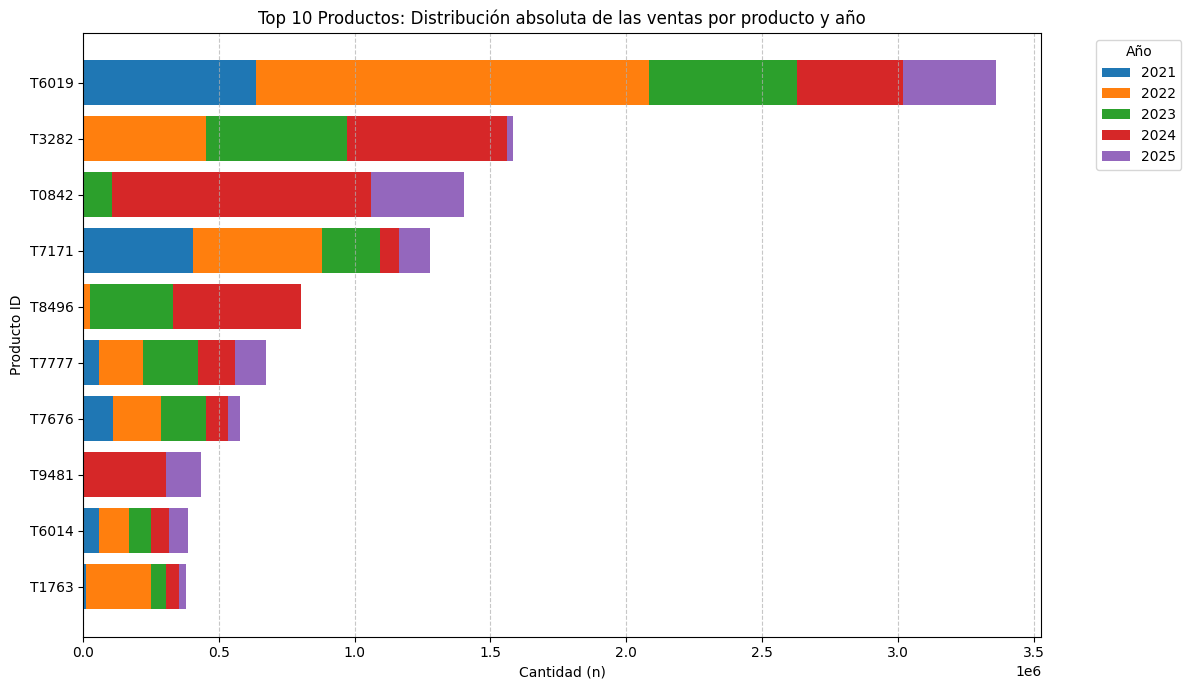

In [ ]:
# Preparar los datos para el gráfico
# Los índices serán los 'Prod ID'
ventas_anual_indexada = ventas_anual.set_index('Prod ID')

# Obtener los años como columnas (excluyendo 'Prod ID' si no se hizo set_index)
años = [col for col in ventas_anual_indexada.columns if str(col).isdigit()]

# Reemplazar posibles NaN con 0 para la suma y el apilado
ventas_anual_indexada = ventas_anual_indexada.fillna(0)

# 1. Calcular la suma total de ventas para cada producto
# Usamos .loc para evitar SettingWithCopyWarning
ventas_anual_indexada.loc[:, 'Total Venta'] = ventas_anual_indexada[años].sum(axis=1)

# 2. Ordenar los productos de forma DESCENDENTE por el 'Total Venta'
# Esto nos asegura que los productos con MAYORES ventas queden al principio.
top_10_productos = ventas_anual_indexada.sort_values(by='Total Venta', ascending=False)

# 3. Seleccionar los 10 principales
top_10_productos = top_10_productos.head(10)

# 4. Invertir el orden para que en el gráfico (barras horizontales)
# el de menor valor esté abajo y el de mayor valor esté arriba (creciente)
productos_para_graficar = top_10_productos.iloc[::-1]

# Eliminar la columna 'Total Venta' ya que solo la usamos para ordenar
productos_para_graficar = productos_para_graficar.drop(columns=['Total Venta'])

print("Top 10 Productos (ordenados de menor a mayor venta total para el gráfico):")
print(productos_para_graficar)

# --- Crear el gráfico de barras horizontales apiladas para los 10 principales ---

# Ajustar el tamaño de la figura dinámicamente según el número de productos (10 en este caso)
fig_height = max(6, len(productos_para_graficar) * 0.7) # Un mínimo de 6 pulgadas de alto
plt.figure(figsize=(12, fig_height))

# Inicializar la base para el apilado
bar_bottom = np.zeros(len(productos_para_graficar))

# Iterar sobre los años y graficar las barras apiladas
for i, anio in enumerate(años):
    plt.barh(
        productos_para_graficar.index,  # Productos en el eje Y (ya ordenados de forma creciente)
        productos_para_graficar[anio],  # Cantidad del año actual
        left=bar_bottom,              # Dónde comienza esta barra (acumulado de años anteriores)
        height=0.8,                   # Grosor de la barra
        label=str(anio)               # Etiqueta para la leyenda
    )
    # Actualizar la base para la siguiente barra apilada
    bar_bottom += productos_para_graficar[anio]

plt.xlabel('Cantidad (n)')
plt.ylabel('Producto ID')
plt.title('Top 10 Productos: Distribución absoluta de las ventas por producto y año')
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left') # Mueve la leyenda para que no se superponga
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta el diseño para que todo quepa sin superponerse
plt.show()

In [ ]:
import numpy as np

#mostrar etiquetas solo si el producto tiene CMG alto
datos_prod['Etiqueta'] = np.where(datos_prod['total_CMG'] > datos_prod['total_CMG'].quantile(0.8),
                                  datos_prod['Prod ID'], "")


#graficando los datos que utiliza el método de la fuerza bruta ABC XYZ
fig = px.scatter(datos_prod,
                 x='total_CMG',
                 y='std_fila',
                 text='Etiqueta',  # para mostrar la etiqueta del punto
                 color='total_CMG',
                 color_continuous_scale=list(reversed(px.colors.sequential.Viridis)),
                 title='Relación entre CMG total y Desviación estándar',
                 labels={'total_CMG': 'CMG Total (USD)', 'std_fila': 'Desvío estándar'})
fig.update_traces(textposition='top center')  # para que las etiquetas no tapen los puntos
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    title_font=dict(size=22, family='Arial', color='black'),
    title_font_weight='bold',
    margin=dict(l=60, r=40, t=80, b=60),
    xaxis=dict(showline=True, linecolor='black', linewidth=1, gridcolor='lightgrey'),
    yaxis=dict(showline=True, linecolor='black', linewidth=1, gridcolor='lightgrey'),
    showlegend=False
)
fig.show()


Los productos de más hacia la derecha son aquellos que más contribución han dejado en los 5 años. Los de más abajo, son los que han
tenido mayor estabilidad de ventas (baja desviación estándar).

In [ ]:
import numpy as np

# Crear columna de etiquetas solo para los productos con CMG en el top 20%
datos_prod['Etiqueta'] = np.where(
    datos_prod['total_CMG'] > datos_prod['total_CMG'].quantile(0.8),
    datos_prod['Prod ID'],
    ""
)

#graficando otros datos del data frame
fig = px.scatter(datos_prod,
                 x='total_CMG',
                 y='Precio (USD/kg)',
                 text='Etiqueta',  # para mostrar la etiqueta del punto
                 color='total_CMG',
                 color_continuous_scale=list(reversed(px.colors.sequential.Viridis)),
                 title='Relación entre CMG total y precios de adquisición para la empresa',
                 labels={'total_CMG': 'CMG Total (USD)', 'Precio (USD/kg)': 'Precio unitario del producto'})
fig.update_traces(textposition='top center')  # para que las etiquetas no tapen los puntos
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    title_font=dict(size=22, family='Arial', color='black'),
    title_font_weight='bold',
    margin=dict(l=60, r=40, t=80, b=60),
    xaxis=dict(showline=True, linecolor='black', linewidth=1, gridcolor='lightgrey'),
    yaxis=dict(showline=True, linecolor='black', linewidth=1, gridcolor='lightgrey'),
    showlegend=False
)

fig.show()


*Aquellos productos que estén más hacia el centro y más abajo en ambos gráficos sería mejor tener altos stocks.*


In [ ]:
#demás features:
fig1 = px.box(datos_prod, y='VU (semanas)', title='Distribución de Vida Útil',hover_data="Prod ID")
fig1.show()

fig2 = px.box(datos_prod, y='Tiempo de entrega (semanas)', title='Distribución de Lead Time de Entrega',hover_data="Prod ID")
fig2.show()

fig3 = px.box(datos_prod, y='Cantidad de clientes históricamente (unidad)', title='Distribución de Clientes por Producto',hover_data="Prod ID")
fig3.show()

#los gráficos están hechos para que si nos paramos arriba de los puntos outliers, nos dice el nombre (gracias al hover_data)

#lo que yo diría de acá es que aquellos que tienen mayor cantidad de clientes que la media tienen más probabilidad de que quiera tener stock porque hay
# chance de que si alguno falla, otro lo lleva. Son el T6019, T8278,T7171, T3646, T5102, T7676, T5013
#también que aquel outlier con baja vida útil, quedaría fuera de cualquier stockeo, si tiene baja VU se me puede vencer en stock (este es el T3191)
#con el de lead time a simple vista no veo mucho

In [ ]:
#no tuvo sentido esto que hice, pero si alguno lo quiere probar y le encuentra algún sentido, retire los #
#instalando statsmodels para ver tendencias
#!pip install statsmodels

In [ ]:
#recuerden sacar todos los #, incluso el de adelante de title
#fig = px.scatter(datos_prod, x='total_CMG', y='std_fila', trendline='ols',
                 #title='CMG Total vs STD con tendencia')
#fig.show()

#**Parte 3: Clustering y resultados**

Empezamos a probar con el método K-means:

In [ ]:
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from zipfile import ZipFile
import io
from urllib.request import urlopen
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# Se consideran las del dataset de datos_prod. Vamos a iniciar haciendo solo con los datos que se usaron en la fuerza bruta
X = datos_prod[['std_fila','total_CMG']]

# Estandarizamos las variables:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X);

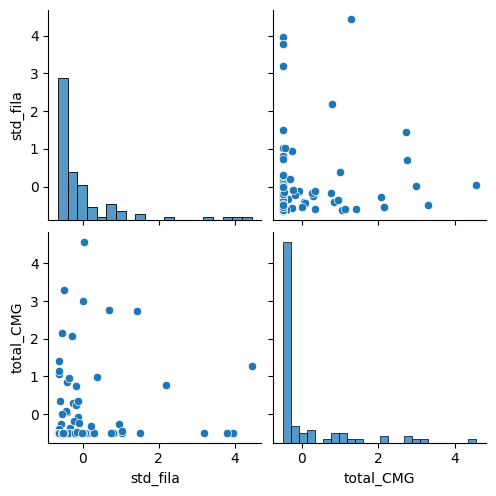

In [ ]:
import pandas as pd
import seaborn as sns

# Crear DataFrame con nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=['std_fila', 'total_CMG'])

# Hacer el pairplot con nombres de variables
plot01 = sns.pairplot(X_scaled_df, corner=False)


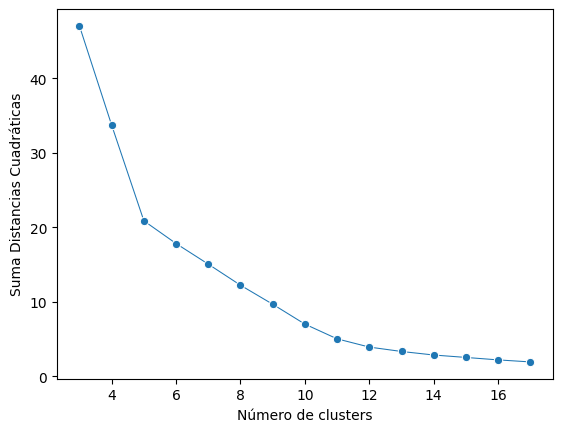

In [ ]:
# Se instancia una lista vacía, en la que se almacenará la suma de distancias
sq_distances = []
# ACTIVIDAD: Elegir un set de valores de K apropiados para probar
k_values = range(3, 18)

# Se entrenan 9 K-means con los valores de K almacenados en k_values
for k in k_values:
    kmeans = KMeans(n_clusters = k, n_init = 30, random_state = 0) # Se instancia K-means, con el valor de K dado
    kmeans.fit(X_scaled) # Se aplica método fit
    sq_distances.append(kmeans.inertia_) # Se almacena la suma de distancias (se aplica el método inertia_)

# Se graficó las sumas de las distancias
sns.lineplot(x=k_values, y=sq_distances, marker='o', size=30, legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');

In [ ]:
centroides_anteriores=[
 [-0.4082859, -0.38903777],
 [ 0.34167409, 3.27072171],
 [ 3.51155543, 0.11470621],
 [-0.35458901, 1.26596618],
 [ 0.76566434, -0.45259716]]

In [ ]:
#Podemos tomar 2 opciones.. Como que la caída abrupta abrupta se detiene en los 5 gruos o en los 11/12. El tema es que la tecnica ABC XYZ
#tiene 9 grupos, osea que inevitablemente va a haber grupos más allá de 9 que igual no nos interesarían.
#Instanciamos el modelo de K-Means y lo entrenamos. Almacenamos las predicciones.
#Como el modelo ABC XYZ tiene 9 grupos, intentaremos hacer 9 grupos

k_clusters = 5
kmeans = KMeans(n_clusters = k_clusters, n_init = 15, max_iter = 200,random_state=42) # LD Colocamos la semilla con el "random_state" para que
#no se cambie la numeracion de los cluster
kmeans.fit(X_scaled)

# Guardamos las etiquetas generadas por el modelo y las coordenadas de los centroides
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print(labels)
print(centroids)


[1 1 0 4 4 4 4 4 4 1 4 4 1 4 4 4 4 2 1 0 4 4 4 3 4 4 3 4 3 4 4 3 4 3 3 3 4
 4 4 4 4 4 4 3 4 4 0 4 4 4 4 2 2 4 4 4 4 0 0 1 3 4 4 4 4 4 2 4 4 4 1 1 4 4
 1 4 4 4 4 4 2 4 4 1 4 4 4 1 4 4]
[[ 0.34167409  3.27072171]
 [ 0.76566434 -0.45259716]
 [ 3.51155543  0.11470621]
 [-0.35458901  1.26596618]
 [-0.4082859  -0.38903777]]


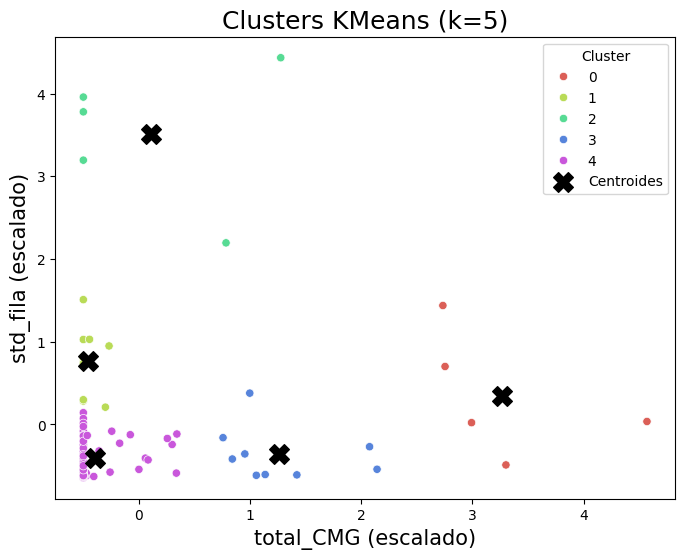

In [ ]:
#LD Rotar los ejes. Se cambiaron en el codigo anterior.

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax01 = plt.subplots(1, 1, figsize=(8,6))

X_plot02 = X_scaled  # Datos estandarizados

# Ahora eje X = total_CMG (columna 1), eje Y = std_fila (columna 0)
sns.scatterplot(x=X_plot02[:,1], y=X_plot02[:,0], hue=labels,
                palette=sns.color_palette("hls", k_clusters),
                legend='full', ax=ax01)

# Graficar centroides (intercambiando columnas también)
ax01.scatter(centroids[:,1], centroids[:,0],
            s=200, c='black', marker='X', label='Centroides')

# Etiquetas de los ejes
ax01.set_xlabel('total_CMG (escalado)', fontsize=15)
ax01.set_ylabel('std_fila (escalado)', fontsize=15)

# Título y leyenda
ax01.set_title('Clusters KMeans (k=5)', fontsize=18)
ax01.legend(title='Cluster')

plt.show()


In [ ]:
# Imprimimos las etiquetas
pd.DataFrame(labels)[0].value_counts()

,count
0,
4,60
1,11
3,9
0,5
2,5


In [ ]:
datos_prod['Cluster'] = kmeans.labels_
print(datos_prod)
CMG_min=datos_prod['total_CMG'].min()
CMG_max=datos_prod['total_CMG'].max()
std_min=datos_prod['std_fila'].min()
std_max=datos_prod['std_fila'].max()
print(CMG_min)
print(CMG_max)
print(std_min)
print(std_max)

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
0    T1981            0.000                           11         104.4   
1    T1872            0.000                           13          52.2   
2    T1763            0.798                           12         261.0   
3    T1654            1.056                           12         261.0   
4    T1545            0.000                           13          52.2   
..     ...              ...                          ...           ...   
86   T0387            0.000                            8         104.4   
87   T0278            0.000                           12          52.2   
88   T0169            0.026                            8          52.2   
89   T0091            0.000                           19         156.6   
91   T0073            0.000                           16         104.4   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                         

In [ ]:
K1 = datos_prod[datos_prod['Cluster'] == 1]
print(K1)
K1_sm=K1['std_fila'].min() / std_min #Si esto da un valor alto, significa que tiene una alta std min el grupo (es decir, más cercano a Y/Z)- Si es casi 1, es X
K1_SM=K1['std_fila'].max() / std_max #Valor casi 0 es X, valor casi 1, es Z
K1_cm=K1['total_CMG'].min() / (CMG_min+0.001) #valor casi 1 es A, por encima es tirando a B/C
K1_CM=K1['total_CMG'].max() / CMG_max #valor casi 0 es A, valor casi 1 es B/C


print(f"K1_sm (std min rel.): {K1_sm:.2f}")
print(f"K1_SM (std max rel.): {K1_SM:.2f}")
print(f"K1_cm (CMG min rel.): {K1_cm:.2f}")
print(f"K1_CM (CMG max rel.): {K1_CM:.2f}")

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
0    T1981            0.000                           11         104.4   
1    T1872            0.000                           13          52.2   
9    T2861            0.000                           13          52.2   
12   T2534            0.000                            8          52.2   
19   T3373            0.000                           17          52.2   
60   T7878            0.000                           12         104.4   
71   T9481            0.050                           12          78.3   
72   T9572            0.000                            3         104.4   
75   T9845            0.000                            8          52.2   
84   T0515            0.131                           12          52.2   
88   T0169            0.026                            8          52.2   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                         

In [ ]:
K2 = datos_prod[datos_prod['Cluster'] == 2]
print(K2)
K2_sm=K2['std_fila'].min() / std_min
K2_SM=K2['std_fila'].max() / std_max
K2_cm=K2['total_CMG'].min() / (CMG_min+0.001)
K2_CM=K2['total_CMG'].max() / CMG_max

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
18   T3282            0.000                            8         156.6   
52   T6019            0.050                           20          78.3   
53   T7171            0.095                           20          78.3   
67   T8496            0.000                           24          78.3   
81   T0842            0.000                           12          78.3   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
18                                            21         0.000000   
52                                            21         0.295833   
53                                            14         0.287500   
67                                             1         0.470833   
81                                             2         0.441667   

        std_fila  total_ventas   total_CMG Etiqueta  Cluster  
18  44823.415831     1582500.0       0.000                 2  
52  49454.0323

In [ ]:
K3 = datos_prod[datos_prod['Cluster'] == 3]
print(K3)
K3_sm=K3['std_fila'].min() / std_min
K3_SM=K3['std_fila'].max() / std_max
K3_cm=K3['total_CMG'].min() / (CMG_min+0.001)
K3_CM=K3['total_CMG'].max() / CMG_max


# LD Imprimir resultados
print(f"\nK3 - std_fila mínimo (relativo a std_min): {K3_sm:.2f}")
print(f"K3 - std_fila máximo (relativo a std_max): {K3_SM:.2f}")
print(f"K3 - total_CMG mínimo (relativo a CMG_min): {K3_cm:.2f}")
print(f"K3 - total_CMG máximo (relativo a CMG_max): {K3_CM:.2f}")

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
24   T3828            4.700                           23         104.4   
27   T4822            7.538                           20         104.4   
29   T4644            8.991                           22         104.4   
32   T4377            1.139                           12         156.6   
34   T4199            7.479                           20         156.6   
35   T5101            1.510                           28         156.6   
36   T5102            0.854                           12         156.6   
44   T6011            1.072                           17         104.4   
61   T7979            0.598                            6         104.4   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
24                                             2         7.100000   
27                                             6         7.500000   
29                                             4    

In [ ]:
K4 = datos_prod[datos_prod['Cluster'] == 4]
print(K4)
K4_sm=K4['std_fila'].min() / std_min
K4_SM=K4['std_fila'].max() / std_max
K4_cm=K4['total_CMG'].min() / (CMG_min+0.001)
K4_CM=K4['total_CMG'].max() / CMG_max

   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
3    T1654            1.056                           12         261.0   
4    T1545            0.000                           13          52.2   
5    T1436            0.000                            8         156.6   
6    T1327            0.000                            8         156.6   
7    T1218            0.000                            8         156.6   
8    T2979            0.000                            8         156.6   
10   T2752            0.000                           11         104.4   
11   T2643            0.103                           12         104.4   
13   T2425            0.673                           11         104.4   
14   T2316            0.000                            8         104.4   
15   T2297            0.000                            8         104.4   
17   T3191            0.000                            4          26.1   
21   T3555            0.000           

In [ ]:
K0 = datos_prod[datos_prod['Cluster'] == 0]
print(K0)
K0_sm=K0['std_fila'].min() / std_min
K0_SM=K0['std_fila'].max() / std_max
K0_cm=K0['total_CMG'].min() / (CMG_min+0.001)
K0_CM=K0['total_CMG'].max() / CMG_max

# LD agegar impresion
print(f"\nK0 - std_fila mínimo (relativo a std_min): {K0_sm:.2f}")
print(f"K0 - std_fila máximo (relativo a std_max): {K0_SM:.2f}")
print(f"K0 - total_CMG mínimo (relativo a CMG_min): {K0_cm:.2f}")
print(f"K0 - total_CMG máximo (relativo a CMG_max): {K0_CM:.2f}")


   Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
2    T1763            0.798                           12         261.0   
20   T3464            5.137                           19          52.2   
47   T6014            0.846                           12         104.4   
58   T7676            0.828                           16         104.4   
59   T7777            0.456                           16         104.4   

    Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
2                                             14         0.750000   
20                                             4         4.708333   
47                                             5         1.333333   
58                                            10         0.770833   
59                                             5         0.770833   

        std_fila  total_ventas     total_CMG Etiqueta  Cluster  
2   20291.405493     379425.00  302781.15000    T1763        0  
20   1528.

In [ ]:
detect_XYZ=[K0_sm,K1_sm,K2_sm,K3_sm,K4_sm]
print(detect_XYZ)

#Si esto da un valor alto, significa que tiene una alta std min el grupo (es decir, más cercano a Y/Z)- Si es casi 1, es X

#LD En orden nuevo xyz: K4,K3,K0,K1,K2
#En cuestiones de relatividad, el claster K0 es bajo en variabilidad. Un 5% de la variabilidad total de los datos.
#X = K4, K3, K0
#Y = K1
#Z = K2

[66.84465074915154, 364.1293310786779, 1209.8555551499603, 13.520668596243668, 1.0]


In [ ]:
# variabilidad de la SDT
66.84465074915154*100/1209.8555551499603

5.52501085477648

In [ ]:
#corroboramos:
detect_XYZ2=[K0_SM,K1_SM,K2_SM,K3_SM,K4_SM]
print(detect_XYZ2)

#Valor casi 0 es X, valor casi 1, es Z

#LD En orden nuevo xyz: K4,K3,K0,K1,K2

#X - K4, K3
#Y - K0, K1
#Z - K2

[0.41030841232295706, 0.42426799031494344, 1.0, 0.20178072479073275, 0.1552560871306103]


In [ ]:
detect_ABC=[K0_cm,K1_cm,K2_cm,K3_cm,K4_cm]
print(detect_ABC)

#valor casi 1 es A, por encima es tirando a B/C

#0 es que tienen CMG 0, por ende serían C indiscutidamente : K1, K2, K3

# LD nuevo orden ABC: K0, K3. (K1, K2, K4 despreciables)
#A: K0, K3
#B:
#C: K1, K2, K4


[302781150.0, 0.0, 0.0, 117638500.0, 0.0]


In [ ]:
detect_ABC2=[K0_CM,K1_CM,K2_CM,K3_CM,K4_CM]
print(detect_ABC2)

#valor casi 0 es A, valor casi 1 es B/C

#LD nuevo orden K0, K3, K2, K4, K1
#A: K0
#B: K3, K2
#C: K4, K1


[1.0, 0.045603034623808825, 0.35024215625173016, 0.5211060557295595, 0.16597664115575064]


In [ ]:
# Cambiamos los ABC-XYZ con los nuevos resultados.
# Definimos el diccionario de mapeo
mapa_clusters = {
    0: 'AY',
    1: 'CY',
    2: 'BZ',
    3: 'AX',
    4: 'BX',
}

# Creamos una nueva columna con las etiquetas, sin modificar la columna original
datos_prod['Cluster_Etiqueta'] = datos_prod['Cluster'].map(mapa_clusters)

# Mostrar las primeras filas para verificar
print(datos_prod.head())


  Prod ID  CMG av (USD/kg)  Tiempo de entrega (semanas)  VU (semanas)  \
0   T1981            0.000                           11         104.4   
1   T1872            0.000                           13          52.2   
2   T1763            0.798                           12         261.0   
3   T1654            1.056                           12         261.0   
4   T1545            0.000                           13          52.2   

   Cantidad de clientes históricamente (unidad)  Precio (USD/kg)  \
0                                             1         1.250000   
1                                             4         0.931250   
2                                            14         0.750000   
3                                             2         0.750000   
4                                             3         0.658333   

       std_fila  total_ventas  total_CMG Etiqueta  Cluster Cluster_Etiqueta  
0  13659.026701      231000.0       0.00                 1               C

In [ ]:
# LD Para exportar la tabla final

datos_prod.to_excel('/content/drive/MyDrive/Hakaton grupo 4/datos_prod_con_cluster_LD.xlsx', index=False)


#Tiene una columna con las etquetas de los clastering. K0 y K3 son los mejores.

In [ ]:
#La extraigo para comparar con los resultados de la fuerza bruta. Total de tiempo hasta acá para hacer esto: 2,5 horas + EDA que me llevó 3, son 5,5 horas
#El fuerza bruta me llevó casi 12. Si los resultados son similares, correctos, podría decirse que en la mitad del tiempo me dio los resultados
#(no va a ser exactamente igual la clasificación porque en el manual forcé a que me de si o si un grupo de cada combinación, acá no pude forzar nada)

datos_prod.to_excel('resultados_clustering.xlsx', index=False)

#Da bastante bien! haría una iteración más igual a ver si mantiene que solo pierde de vista 2 productos con una CMG total de 6 digitos, los demás con 6 dígitos quedan claramente en los grupos stockeables